```{index} single: application; production planning
```
```{index} single: solver; cbc
```
```{index} single: solver; highs
```
```{index} pandas dataframe
```
```{index} single: Pyomo; parameters
```
```{index} single: Pyomo; sets
```
```{index} single: Pyomo; expressions
```
```{index} simulations
```

# 7.2 Robustness analysis of BIM production plan via simulations

## Preamble: Install Pyomo and a solver

The following cell sets and verifies a global SOLVER for the notebook. If run on Google Colab, the cell installs Pyomo and the HiGHS solver, while, if run elsewhere, it assumes Pyomo and HiGHS have been previously installed. It then sets to use HiGHS as solver via the appsi module and a test is performed to verify that it is available. The solver interface is stored in a global object `SOLVER` for later use.

In [1]:
import sys
 
if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null
 
solver = 'appsi_highs'
 
import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)
 
assert SOLVER.available(), f"Solver {solver} is not available."

## Problem description

This example is a continuation of the BIM chip production problem illustrated [here](../02/bim.ipynb). Recall hat BIM produces logic and memory chips using copper, silicon, germanium, and plastic and that each chip requires the following quantities of raw materials:

| chip   | copper | silicon | germanium | plastic |
|:-------|-------:|--------:|----------:|--------:|
|logic   |    0.4 |       1 |         - |       1 |
|memory  |    0.2 |       - |         1 |       1 |

BIM needs to carefully manage the acquisition and inventory of these raw materials based on the forecasted demand for the chips. Data analysis led to the following prediction of monthly demands:

| chip   | Jan | Feb | Mar | Apr | May | Jun | Jul | Aug | Sep | Oct | Nov | Dec |
|:-------|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
|logic   |  88 | 125 | 260 | 217 | 238 | 286 | 248 | 238 | 265 | 293 | 259 | 244 |
|memory  |  47 |  62 |  81 |  65 |  95 | 118 |  86 |  89 |  82 |  82 |  84 | 66  |

At the beginning of the year, BIM has the following stock:

|copper|silicon|germanium|plastic|
|-----:|------:|--------:|------:|
|   480|  1000 |     1500|  1750 |

The company would like to have at least the following stock at the end of the year:

|copper|silicon|germanium|plastic|
|-----:|------:|--------:|------:|
|   200|   500 |      500|  1000 |

Each raw material can be acquired at each month, but the unit prices vary as follows:

| product  | Jan | Feb | Mar | Apr | May | Jun | Jul | Aug | Sep | Oct | Nov | Dec |
|:---------|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
|copper    |   1 |   1 |   1 |   2 |   2 |   3 |   3 |   2 |   2 |   1 |   1 |   2 |
|silicon   |   4 |   3 |   3 |   3 |   5 |   5 |   6 |   5 |   4 |   3 |   3 |   5 |
|germanium |   5 |   5 |   5 |   3 |   3 |   3 |   3 |   2 |   3 |   4 |   5 |   6 |
|plastic   | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 |

The inventory is limited by a capacity of a total of 9000 units per month, regardless of the type of material of products in stock. The holding costs of the inventory are 0.05 per unit per month regardless of the material type. Due to budget constraints, BIM cannot spend more than 5000 per month on acquisition.

BIM aims at minimizing the acquisition and holding costs of the materials while meeting the required quantities for production. The production is made to order, meaning that no inventory of chips is kept.

Let us model the material acquisition planning and solve it optimally based on the forecasted chip demand above.

In [2]:
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo

demand_data = """
chip, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
logic, 88, 125, 260, 217, 238, 286, 248, 238, 265, 293, 259, 244
memory, 47, 62, 81, 65, 95, 118, 86, 89, 82, 82, 84, 66
"""

demand_chips = pd.read_csv(StringIO(demand_data), index_col="chip")
display(demand_chips)

price_data = """
product, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
copper, 1, 1, 1, 2, 2, 3, 3, 2, 2, 1, 1, 2
silicon, 4, 3, 3, 3, 5, 5, 6, 5, 4, 3, 3, 5
germanium, 5, 5, 5, 3, 3, 3, 3, 2, 3, 4, 5, 6
plastic, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1
"""

price = pd.read_csv(StringIO(price_data), index_col="product")
display(price)

use = dict()
use["logic"] = {"silicon": 1, "plastic": 1, "copper": 4}
use["memory"] = {"germanium": 1, "plastic": 1, "copper": 2}
use = pd.DataFrame.from_dict(use).fillna(0).astype(int)
material_demand = use.dot(demand_chips)

existing = pd.Series(
    {"silicon": 1000, "germanium": 1500, "plastic": 1750, "copper": 4800}
)
eot_inventory = pd.Series(
    {"silicon": 500, "germanium": 500, "plastic": 1000, "copper": 2000}
)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
chip,,,,,,,,,,,,
logic,88,125,260,217,238,286,248,238,265,293,259,244
memory,47,62,81,65,95,118,86,89,82,82,84,66


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
product,,,,,,,,,,,,
copper,1.0,1.0,1.0,2.0,2.0,3.0,3.0,2.0,2.0,1.0,1.0,2.0
silicon,4.0,3.0,3.0,3.0,5.0,5.0,6.0,5.0,4.0,3.0,3.0,5.0
germanium,5.0,5.0,5.0,3.0,3.0,3.0,3.0,2.0,3.0,4.0,5.0,6.0
plastic,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [3]:
# we store all the problem data in one object to easily perform folding-horizon simulations
def initialize_problem_data():
    problem_data = {
        "price": price.copy(deep=True),
        "inventory_cost": 0.05,
        "material_demand": material_demand.copy(deep=True),
        "demand_chips_ref": demand_chips.copy(deep=True),
        "demand_chips_simulation": demand_chips.copy(deep=True),
        "use": use.copy(deep=True),
        "existing": existing.copy(deep=True),
        "eot_inventory": eot_inventory.copy(deep=True),
        "stock_limit": 9000,
        "month_budget": 2500,
    }
    return problem_data


def ShowTableOfPyomoVariables(X, I, J):
    return pd.DataFrame.from_records(
        [[pyo.value(X[i, j]) for j in J] for i in I], index=I, columns=J
    ).round(decimals=2)


def BIMProductAcquisitionAndInventory(problem_data):
    demand = problem_data["use"].dot(problem_data["demand_chips_ref"])
    acquisition_price = problem_data["price"]
    existing = problem_data["existing"]
    desired = problem_data["eot_inventory"]
    stock_limit = problem_data["stock_limit"]
    month_budget = problem_data["month_budget"]

    m = pyo.ConcreteModel("Product acquisition and inventory")

    periods = demand.columns
    products = demand.index
    first = periods[0]
    prev = {j: i for i, j in zip(periods, periods[1:])}
    last = periods[-1]

    m.T = pyo.Set(initialize=periods)
    m.P = pyo.Set(initialize=products)
    m.PT = m.P * m.T  # to avoid internal set bloat

    m.x = pyo.Var(m.PT, domain=pyo.NonNegativeReals)
    m.s = pyo.Var(m.PT, domain=pyo.NonNegativeReals)

    @m.Param(m.PT)
    def pi(m, p, t):
        return acquisition_price.loc[p][t]

    @m.Param(m.PT)
    def h(m, p, t):
        return 0.05  # the holding cost

    @m.Param(m.PT)
    def delta(m, p, t):
        return demand.loc[p, t]

    @m.Expression()
    def acquisition_cost(m):
        return pyo.quicksum(m.pi[p, t] * m.x[p, t] for p in m.P for t in m.T)

    @m.Expression()
    def inventory_cost(m):
        return pyo.quicksum(m.h[p, t] * m.s[p, t] for p in m.P for t in m.T)

    @m.Objective(sense=pyo.minimize)
    def total_cost(m):
        return m.acquisition_cost + m.inventory_cost

    @m.Constraint(m.PT)
    def balance(m, p, t):
        if t == first:
            return existing[p] + m.x[p, t] == m.delta[p, t] + m.s[p, t]
        else:
            return m.x[p, t] + m.s[p, prev[t]] == m.delta[p, t] + m.s[p, t]

    @m.Constraint(m.P)
    def finish(m, p):
        return m.s[p, last] >= desired[p]

    @m.Constraint(m.T)
    def inventory(m, t):
        return pyo.quicksum(m.s[p, t] for p in m.P) <= stock_limit

    @m.Constraint(m.T)
    def budget(m, t):
        return pyo.quicksum(m.pi[p, t] * m.x[p, t] for p in m.P) <= month_budget

    return m


problem_data = initialize_problem_data()
m = BIMProductAcquisitionAndInventory(problem_data)
SOLVER.solve(m)

print(f"The optimal solution yields a total cost of {pyo.value(m.total_cost):.2f}\n")

problem_data["purchases"] = ShowTableOfPyomoVariables(m.x, m.P, m.T)
problem_data["stock"] = ShowTableOfPyomoVariables(m.s, m.P, m.T)

display(problem_data["purchases"])
display(problem_data["stock"])

The optimal solution yields a total cost of 23580.34



,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,0.0,833.33,225.67,833.33,0.00,0.0,0.0,0.00,368.67,0.0,0.0,0.0
plastic,0.0,0.00,0.00,0.00,0.00,0.0,266.0,327.00,722.00,0.0,343.0,1310.0
copper,666.0,0.00,1823.00,0.00,310.78,0.0,0.0,1233.65,476.57,2500.0,2465.7,682.3
germanium,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,912.0,1620.33,1586.0,2202.33,1964.33,1678.33,1430.33,1192.33,1296.0,1003.0,744.0,500.0
plastic,1615.0,1428.00,1087.0,805.00,472.00,68.00,0.00,0.00,375.0,0.0,0.0,1000.0
copper,5020.0,4396.00,5017.0,4019.00,3187.78,1807.78,643.78,747.43,0.0,1164.0,2425.7,2000.0
germanium,1453.0,1391.00,1310.0,1245.00,1150.00,1032.00,946.00,857.00,775.0,693.0,609.0,543.0


## Actual performance of the robust solution

We now perform a stochastic simulation to assess the performance of the robust solutions that we found earlier.

In [21]:
def minimize_missed_demand_in_period(
    inventory, missed_demand, purchases, existing, demand_chips, use, period=None
):
    m = pyo.ConcreteModel("Missed demand in period")

    periods = inventory.columns
    first = periods[0]
    prev = {j: i for i, j in zip(periods, periods[1:])}
    last = periods[-1]

    m.P = pyo.Set(initialize=list(use.columns))
    m.M = pyo.Set(initialize=list(use.index))

    # Decision variable: nb of chips to produce >= 0
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeReals)

    # Decision variable: missed demand
    m.s = pyo.Var(m.P, domain=pyo.NonNegativeReals)

    # Constraint: per resource we cannot use more than there is
    @m.Constraint(m.M)
    def resource_constraint(m, i):
        return (
            pyo.quicksum(m.x[p] * use.loc[i, p] for p in m.P)
            <= inventory.loc[i, prev[period]] + purchases.loc[i, period]
        )

    # Constraint: production + missed demand = total demand in this period
    @m.Constraint(m.P)
    def produced_plus_unmet(m, p):
        return m.x[p] + m.s[p] == demand_chips.loc[p, period]

    # Objective - minimize the missed demand
    @m.Objective(sense=pyo.minimize)
    def total_unmet(m):
        return pyo.quicksum(m.s[p] for p in m.P)

    SOLVER.solve(m)

    # update inventory
    for i in m.M:
        inventory.loc[i, period] = (
            inventory.loc[i, prev[period]]
            + purchases.loc[i, period]
            - sum([pyo.value(m.x[p]) * use.loc[i, p] for p in m.P])
        )

    # update missed demand
    for p in m.P:
        missed_demand.loc[p, period] = pyo.value(m.s[p])

    return 0


def simulation_per_trajectory(purchases, existing, demand_chips, use):
    # Set up the table to store inventory evolution
    inventory = pd.DataFrame(index=purchases.index, columns=purchases.columns)
    inventory = pd.concat(
        [pd.DataFrame(existing, index=existing.index, columns=["existing"]), inventory],
        axis=1,
    )

    # Set up the DF to store missed demand information
    missed_demand = pd.DataFrame(
        np.zeros((len(demand_chips.index), len(purchases.columns))),
        index=demand_chips.index,
        columns=purchases.columns,
    )

    # Proper simulation
    for period in inventory.columns[1:]:
        minimize_missed_demand_in_period(
            inventory, missed_demand, purchases, existing, demand_chips, use, period
        )

    return inventory.iloc[:, 1:], missed_demand


def simulate_performance(problem_data, n=50, rho=0.05, seed=0):
    rng = np.random.default_rng(seed)

    results = []
    for i in range(n):
        perturbed_demand = problem_data["demand_chips_simulation"].applymap(
            lambda x: x * (1 + rho * (1 - 2 * rng.random()))
        )
        inv, md = simulation_per_trajectory(
            problem_data["purchases"], problem_data["existing"], perturbed_demand, use
        )
        results.append({"inventory": inv, "missing_demand": md})

    MissingDemand = pd.concat(
        [i["missing_demand"] for i in results], keys=[i for i in range(len(results))]
    )
    MissingDemand = MissingDemand.astype("float").swaplevel()

    InventoryEvolution = pd.concat(
        [i["inventory"] for i in results], keys=[i for i in range(len(results))]
    )
    InventoryEvolution = InventoryEvolution.astype("float").swaplevel()

    return {"MissingDemand": MissingDemand, "InventoryEvolution": InventoryEvolution}


def report(MissingDemand, InventoryEvolution, problem_data):
    # list to store DFs with per-group computed quantiles at various levels
    average_missed_demand = MissingDemand.groupby(level=0).mean().transpose()

    # figure settings
    colors = plt.cm.tab20c
    plt.rcParams.update({"font.size": 14})

    # build a plot with as many subplots as there are chip types
    fig, axis = plt.subplots(figsize=(10, 5))
    average_missed_demand.plot(
        ax=axis,
        drawstyle="steps-mid",
        grid=True,
        lw=2,
        color=[colors(0), colors(4)],
        alpha=0.9,
    )
    plt.xticks(
        ticks=np.arange(len(average_missed_demand.index)),
        labels=average_missed_demand.index,
    )
    # axis.set_title("Missed demand of chips under " + str(rho * 100) + "% uncertainty")
    axis.set_xlabel("Month")
    axis.set_ylabel("Average missed demand")
    axis.legend(["Logic chips", "Memory chips"], loc="upper left")
    plt.tight_layout()
    plt.savefig(
        "bim_robust_missed_demand.svg", format="svg", dpi=300, bbox_inches="tight"
    )

    realized_inv_cost = (
        InventoryEvolution.groupby(level=0).mean().sum(axis=1).sum()
        * problem_data["inventory_cost"]
    )
    print(
        f'Purchasing cost: {(problem_data["price"] * problem_data["purchases"]).sum().sum():.2f}'
    )
    print(
        f'Theoretical inventory cost: {(problem_data["stock"] * problem_data["inventory_cost"]).sum().sum():.2f}\n'
    )
    print(f"Simulated realized inventory cost: {realized_inv_cost:.2f}")
    print(
        f"Simulated average missed demand for logic chips is {MissingDemand.groupby(level = 0).mean().sum(axis = 1)[0]:.3f} and for memory chips is {MissingDemand.groupby(level = 0).mean().sum(axis = 1)[1]:.3f}\n"
    )
    print(
        "Plot of missed chips demand over time under "
        + str(rho * 100)
        + "% uncertainty\n"
    )
    plt.show()

We now simulate 50 trajectories assuming there is a $\rho=8\%$ uncertainty around the nominal demand.

In [5]:
rho = 0.08
N_sim = 50

problem_data["demand_chips_ref"] = demand_chips
m = BIMProductAcquisitionAndInventory(problem_data)
SOLVER.solve(m)

problem_data["purchases"] = ShowTableOfPyomoVariables(m.x, m.P, m.T)
problem_data["stock"] = ShowTableOfPyomoVariables(m.s, m.P, m.T)

SimResults = simulate_performance(problem_data, N_sim, rho)

The simulation results report a sllighly higher inventory cost and a nonzero amount of missed chip demand.

Purchasing cost: 20309.77
Theoretical inventory cost: 3270.57

Simulated realized inventory cost: 3309.54
Simulated average missed demand for logic chips is 4.543 and for memory chips is 13.154

Plot of missed chips demand over time under 8.0% uncertainty



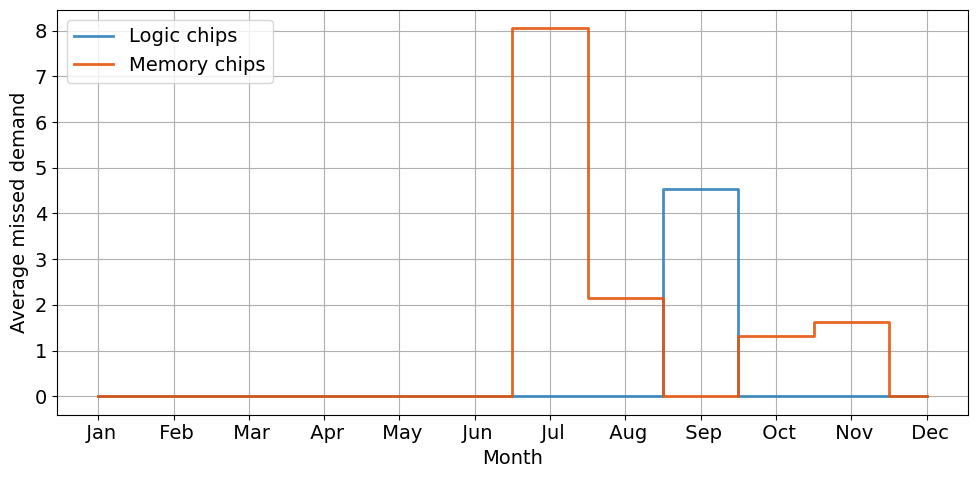

In [22]:
report(SimResults["MissingDemand"], SimResults["InventoryEvolution"], problem_data)